Section 3

In [71]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import os

plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams.update({
    "font.size":       18,
    "axes.titlesize":  20,
    "axes.labelsize":  18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 15
})

# original colormap
orig = plt.get_cmap("Dark2")
set2 = plt.get_cmap("Set2")
all_colors = orig.colors
new_colors = np.delete(all_colors, 1, axis=0)
new_colors = np.insert(new_colors, 1, set2.colors[1], axis=0)
cmap = ListedColormap(new_colors, name="Dark2_no2")

# === CONFIG ===
HUMAN_DATA_ROOT = '../../../human_annotation_data'
DATA_ROOT = '../../../data'
SCORES_DIR = os.path.join(DATA_ROOT, 'fine_tuned_model_scores')
FT_SUFFIX = {
    'structure':  '750_3',
    'jargon':     '750_3',
    'length':     '1000_3',
    'sycophancy': '500_3',
    'vagueness':   '1000_3'
}
BIAS_LIST = ['structure','jargon','length','sycophancy', 'vagueness']

# === Helpers ===
def load_human_annotations(feat):
    path = os.path.join(HUMAN_DATA_ROOT, feat, f'{feat}_grouped_human_annotations.json')
    df = pd.DataFrame(json.load(open(path, encoding='utf-8')))
    df = df[df['most_frequent_preference'].str.lower() != 'tie']
    col_map = {
        'structure':  'more_structured_response',
        'jargon':     'more_jargony_response',
        'length':     'longer_response',
        'sycophancy': 'more_sycophantic_response',
        'vagueness':  'more_vague_response'
    }
    df['human_pref'] = np.where(
        df['most_frequent_preference'] == df[col_map[feat]],
        'perturbed','base'
    )
    return df[['query','human_pref']]

def load_scores(path):
    return pd.DataFrame([json.loads(l) for l in open(path, encoding='utf-8') if l.strip()])

# === Compute stats ===
human_skew = {}
base_means, base_stds = {}, {}
ft_means, ft_stds     = {}, {}

for feat in BIAS_LIST:
    human_df = load_human_annotations(feat)
    human_skew[feat] = (human_df['human_pref']=='perturbed').mean()*100

    base_records, ft_records = [], []
    suffix = FT_SUFFIX[feat]
    dir_   = os.path.join(SCORES_DIR, feat)

    for size in ['2B','3B','8B', '27B']:
        dfb = load_scores(os.path.join(dir_, f'{feat}_scored_{size}.jsonl')).merge(human_df, on='query')
        auto_b = np.where(dfb['perturbed_score']>dfb['base_score'],'perturbed','base')
        base_records.append({'skew':(auto_b=='perturbed').mean()*100,'miscal':(auto_b!=dfb['human_pref']).mean()*100})

        dff = load_scores(os.path.join(dir_, f'{feat}_scored_fine_tuned_{size}_{suffix}.jsonl')).merge(human_df, on='query')
        auto_f = np.where(dff['perturbed_score']>dff['base_score'],'perturbed','base')
        ft_records.append({'skew':(auto_f=='perturbed').mean()*100,'miscal':(auto_f!=dff['human_pref']).mean()*100})

    base_df = pd.DataFrame(base_records)
    ft_df   = pd.DataFrame(ft_records)

    base_means[feat] = base_df.mean()
    base_stds[feat]  = base_df.std()
    ft_means[feat]   = ft_df.mean()
    ft_stds[feat]    = ft_df.std()

# Build DataFrames
bm = pd.DataFrame(base_means).T.loc[BIAS_LIST]
bs = pd.DataFrame(base_stds).T.loc[BIAS_LIST]
fm = pd.DataFrame(ft_means).T.loc[BIAS_LIST]
fs = pd.DataFrame(ft_stds).T.loc[BIAS_LIST]
PLOT_ORDER = ['length', 'structure', 'jargon', 'sycophancy', 'vagueness']
x = np.arange(len(PLOT_ORDER))
print(human_skew)
print(bm)
print(fm)


{'structure': 89.47368421052632, 'jargon': 20.87912087912088, 'length': 33.70786516853933, 'sycophancy': 49.411764705882355, 'vagueness': 14.285714285714285}
                 skew     miscal
structure   89.473684  12.631579
jargon      47.527473  50.274725
length      60.112360  42.134831
sycophancy  46.470588  40.588235
vagueness   60.969388  51.275510
                 skew     miscal
structure   79.473684  17.368421
jargon      21.703297  33.241758
length      44.943820  38.764045
sycophancy  38.529412  44.411765
vagueness   31.122449  28.571429


In [72]:
import numpy as np

# miscal diffs
miscal_diffs = bm['miscal'] - fm['miscal']
print("Average miscal reduction from base to ft:", miscal_diffs.mean())

print("--------------------------------")

print(bm['miscal'].mean())
print(fm['miscal'].mean())

print(bm['skew'].mean())
print(fm['skew'].mean())
print("--------------------------------")

base_diffs = [abs(human_skew[k] - bm['skew'][k]) for k in human_skew]
ft_diffs   = [abs(human_skew[k] - fm['skew'][k]) for k in human_skew]

avg_base_diff = np.mean(base_diffs)
avg_ft_diff   = np.mean(ft_diffs)

print(f"Average base diff: {avg_base_diff:.4f}")
print(f"Average fine-tuned diff: {avg_ft_diff:.4f}")


Average miscal reduction from base to ft: 6.909492733089229
--------------------------------
39.380976236193426
32.4714835031042
60.91069845579135
43.154532376567964
--------------------------------
Average base diff: 20.5355
Average fine-tuned diff: 9.9558


Generative Model Skew/Miscalibration

In [73]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import os

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "font.size":       18,
    "axes.titlesize":  20,
    "axes.labelsize":  18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 15
})

# Build a custom colormap by dropping and substituting colors
orig = plt.get_cmap("Dark2")
set2 = plt.get_cmap("Set2")
tab20 = plt.get_cmap("tab20")
accent = plt.get_cmap("Accent")
set1 = plt.get_cmap("Set1")

# Remove unwanted entries and insert new ones
new_colors = np.delete(orig.colors, 1, axis=0)
new_colors = np.delete(new_colors, 2, axis=0)
new_colors = np.insert(new_colors, 1, set2.colors[1], axis=0)
new_colors = np.insert(new_colors, 1, tab20.colors[1], axis=0)
new_colors = np.insert(new_colors, 2, accent.colors[1], axis=0)
new_colors = np.insert(new_colors, 3, set1.colors[1], axis=0)
cmap = ListedColormap(new_colors, name="CustomDark2")

# === CONFIGURATION ===
GENERATIVE_ROOT  = '../../../llm_evaluation_data'
HUMAN_ROOT = '../../../human_annotation_data'
SCORES_DIR = os.path.join(GENERATIVE_ROOT, 'generative_model_scores')
BIAS_LIST  = ['length','structure','jargon','sycophancy', 'vagueness']
MODELS     = ['gpt-4o', 'claude-3-7', 'gemini-2-5']
col_map = {
    'structure':  'more_structured_response',
    'jargon':     'more_jargony_response',
    'length':     'longer_response',
    'sycophancy': 'more_sycophantic_response',
    'vagueness':  'more_vague_response'
}

# === DATA LOADING HELPERS ===
def load_human_annotations(feat):
    path = os.path.join(HUMAN_ROOT, feat, f'{feat}_grouped_human_annotations.json')
    df = pd.DataFrame(json.load(open(path, encoding='utf-8')))
    df = df[df['most_frequent_preference'].str.lower() != 'tie']
    df['human_pref'] = np.where(
        df['most_frequent_preference'] == df[col_map[feat]],
        'perturbed','base'
    )
    return df[['query','human_pref', col_map[feat]]]


def load_gen_scores(feat, model, human_df):
    human_idx = human_df.set_index('query')
    path = os.path.join(SCORES_DIR, feat, f'{feat}_scored_{model}.jsonl')
    records = []
    for line in open(path, encoding='utf-8'):
        if not line.strip(): continue
        data = json.loads(line)
        q = data['query']
        if q not in human_idx.index: continue
        pert_resp = human_idx.at[q, col_map[feat]]
        pert_slot = 1 if pert_resp=='response_1' else 2
        j = data['judgement']['judgement']
        if j=='Tie': continue
        picked = 1 if j=='Response 1' else 2
        pref = 'perturbed' if picked==pert_slot else 'base'
        records.append({'query':q,'model_pref':pref})
    return pd.DataFrame(records)

# === COMPUTE HUMAN SKEW ===
human_skew = { feat: (load_human_annotations(feat)['human_pref']=='perturbed').mean()*100
               for feat in BIAS_LIST }

# === COLLECT MODEL METRICS ===
rows = []
for feat in BIAS_LIST:
    human_df = load_human_annotations(feat)
    for model in MODELS:
        dfm = load_gen_scores(feat, model, human_df).merge(human_df, on='query')
        skew   = (dfm['model_pref']=='perturbed').mean()*100
        miscal = (dfm['model_pref']!=dfm['human_pref']).mean()*100
        rows.append({'bias':feat,'model':model,'skew':skew,'miscal':miscal})
df_stats   = pd.DataFrame(rows)
skew_piv   = df_stats.pivot(index='bias', columns='model', values='skew')
miscal_piv = df_stats.pivot(index='bias', columns='model', values='miscal')
PLOT_ORDER = BIAS_LIST


Plotting

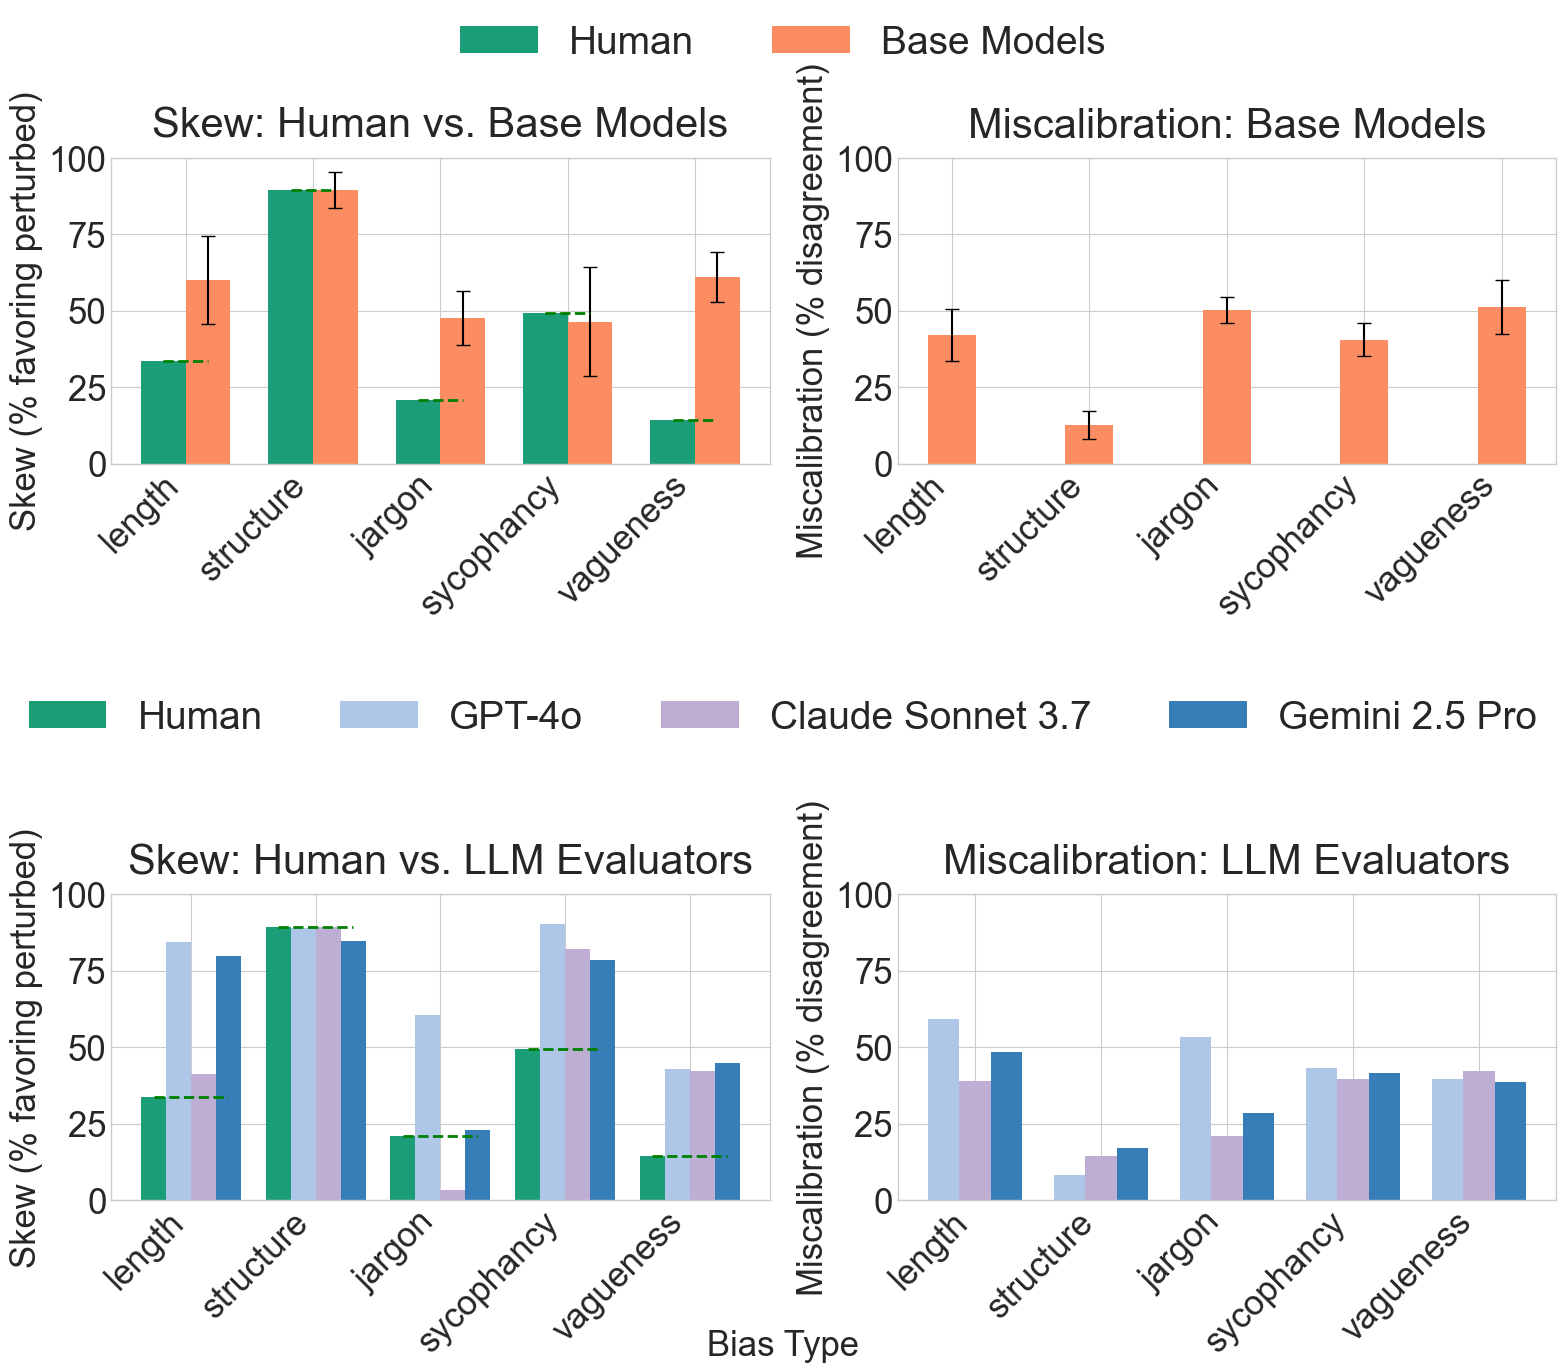

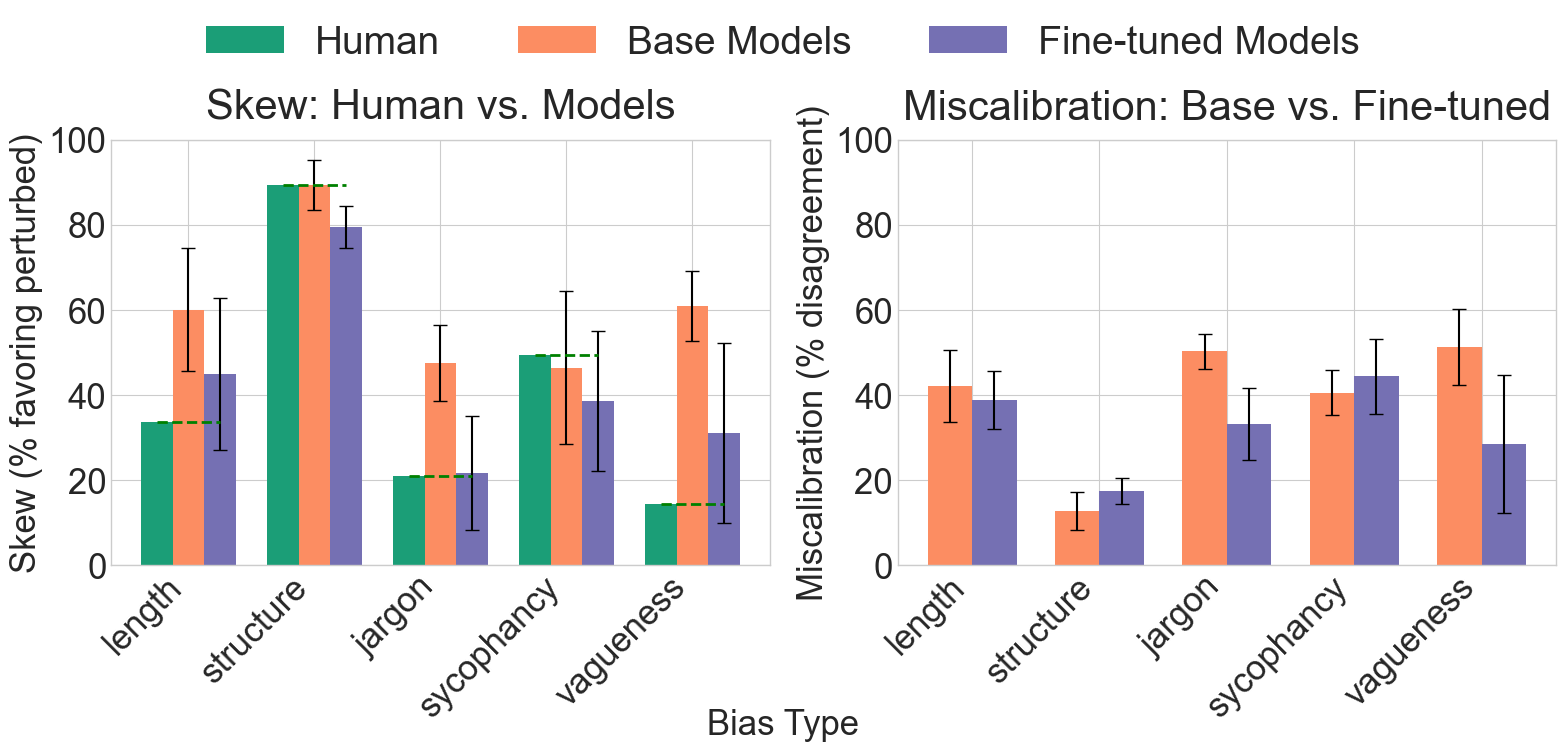

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# Font size constants
PLOT_FONTSIZE = {
    'title': 30,
    'label': 25,
    'tick': 25,
    'legend': 25,
    'figure': 14
}

# Color setup - RESTORING ORIGINAL COLORS
a = plt.get_cmap("Dark2").colors
b = plt.get_cmap("Set2").colors
deleted = np.delete(a, 1, axis=0)
new_colors = np.insert(deleted, 1, b[1], axis=0)
orig = ListedColormap(new_colors, name="Custom2")
# For generative plots, use the original custom colormap logic
set2 = plt.get_cmap("Set2")
tab20 = plt.get_cmap("tab20")
accent = plt.get_cmap("Accent")
set1 = plt.get_cmap("Set1")
all_colors = orig.colors
new_colors = np.delete(all_colors, 1, axis=0)
new_colors = np.delete(new_colors, 2, axis=0)
new_colors = np.insert(new_colors, 1, set2.colors[1], axis=0)
new_colors = np.insert(new_colors, 1, tab20.colors[1], axis=0)
new_colors = np.insert(new_colors, 2, accent.colors[1], axis=0)
new_colors = np.insert(new_colors, 3, set1.colors[1], axis=0)
cmap = ListedColormap(new_colors, name="CustomDark2")


### PLOTTING FUNCTIONS ###

def plot_skew_base(ax):
    """Plot skew comparison between human and base models."""
    width = 0.35
    ax.bar(x - width/2, [human_skew[f] for f in PLOT_ORDER], width,
           label='Human', color=orig.colors[0])
    ax.bar(x + width/2, bm.loc[PLOT_ORDER,'skew'], width,
           yerr=bs.loc[PLOT_ORDER,'skew'], capsize=5,
           label='Base Models', color=orig.colors[1])
    
    for idx, feat in enumerate(PLOT_ORDER):
        ax.hlines(human_skew[feat], idx - width/2, idx + width/2,
                 colors='green', linestyles='dashed', linewidth=2)
    
    ax.set_xticks(x)
    ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right', fontsize=PLOT_FONTSIZE['tick'])
    ax.set_ylabel('Skew (% favoring perturbed)', fontsize=PLOT_FONTSIZE['label'])
    ax.set_title('Skew: Human vs. Base Models', pad=15, fontsize=PLOT_FONTSIZE['title'])
    ax.tick_params(axis='y', labelsize=PLOT_FONTSIZE['tick'])

def plot_miscal_base(ax):
    """Plot miscalibration for base models."""
    width = 0.35
    ax.bar(x, bm.loc[PLOT_ORDER,'miscal'], width,
           yerr=bs.loc[PLOT_ORDER,'miscal'], capsize=5,
           label='Base Models', color=orig.colors[1])
    ax.set_xticks(x)
    ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right', fontsize=PLOT_FONTSIZE['tick'])
    ax.set_ylabel('Miscalibration (% disagreement)', fontsize=PLOT_FONTSIZE['label'])
    ax.set_title('Miscalibration: Base Models', pad=15, fontsize=PLOT_FONTSIZE['title'])
    ax.tick_params(axis='y', labelsize=PLOT_FONTSIZE['tick'])

def plot_skew_with_ft(ax):
    """Plot skew comparison including fine-tuned models."""
    width = 0.25
    ax.bar(x - width, [human_skew[f] for f in PLOT_ORDER], width,
           label='Human', color=orig.colors[0])
    ax.bar(x, bm.loc[PLOT_ORDER,'skew'], width,
           yerr=bs.loc[PLOT_ORDER,'skew'], capsize=5,
           label='Base Models', color=orig.colors[1])
    ax.bar(x + width, fm.loc[PLOT_ORDER,'skew'], width,
           yerr=fs.loc[PLOT_ORDER,'skew'], capsize=5,
           label='Fine-tuned Models', color=orig.colors[2])
    
    for idx, feat in enumerate(PLOT_ORDER):
        ax.hlines(human_skew[feat], idx - width, idx + width,
                 colors='green', linestyles='dashed', linewidth=2)
    
    ax.set_xticks(x)
    ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right', fontsize=PLOT_FONTSIZE['tick'])
    ax.set_ylabel('Skew (% favoring perturbed)', fontsize=PLOT_FONTSIZE['label'])
    ax.set_title('Skew: Human vs. Models', pad=15, fontsize=PLOT_FONTSIZE['title'])
    ax.tick_params(axis='y', labelsize=PLOT_FONTSIZE['tick'])

def plot_miscal_with_ft(ax):
    """Plot miscalibration comparison including fine-tuned models."""
    width = 0.35
    ax.bar(x - width/2, bm.loc[PLOT_ORDER,'miscal'], width,
           yerr=bs.loc[PLOT_ORDER,'miscal'], capsize=5,
           label='Base Models', color=orig.colors[1])
    ax.bar(x + width/2, fm.loc[PLOT_ORDER,'miscal'], width,
           yerr=fs.loc[PLOT_ORDER,'miscal'], capsize=5,
           label='Fine-tuned Models', color=orig.colors[2])
    ax.set_xticks(x)
    ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right', fontsize=PLOT_FONTSIZE['tick'])
    ax.set_ylabel('Miscalibration (% disagreement)', fontsize=PLOT_FONTSIZE['label'])
    ax.set_title('Miscalibration: Base vs. Fine-tuned', pad=15, fontsize=PLOT_FONTSIZE['title'])
    ax.tick_params(axis='y', labelsize=PLOT_FONTSIZE['tick'])

def plot_skew_generative(ax):
    """Plot skew comparison between human and LLM evaluators with original colors."""
    width = 0.2
    ax.bar(x - 1.5*width, [human_skew[f] for f in PLOT_ORDER], width,
           label='Human', color=orig.colors[0])  # Use original blue for human
    
    # Use the custom color map for models
    for i, model in enumerate(MODELS):
        ax.bar(x + (i-0.5)*width, skew_piv.loc[PLOT_ORDER, model], width,
               label=model, color=cmap(i+1))  # Note: i+1 to skip human color
    
    for idx, feat in enumerate(PLOT_ORDER):
        ax.hlines(human_skew[feat], idx - 1.5*width, idx + 1.5*width,
                 colors='green', linestyles='dashed', linewidth=2)
    
    ax.set_xticks(x)
    ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right', fontsize=PLOT_FONTSIZE['tick'])
    ax.set_ylabel('Skew (% favoring perturbed)', fontsize=PLOT_FONTSIZE['label'])
    ax.set_title('Skew: Human vs. LLM Evaluators', pad=15, fontsize=PLOT_FONTSIZE['title'])
    ax.tick_params(axis='y', labelsize=PLOT_FONTSIZE['tick'])

def plot_miscal_generative(ax):
    """Plot miscalibration for LLM evaluators with original colors."""
    width = 0.25
    for i, model in enumerate(MODELS):
        ax.bar(x + (i-1)*width, miscal_piv.loc[PLOT_ORDER, model], width,
               label=model, color=cmap(i+1))  # Note: i+1 to skip human color
    
    ax.set_xticks(x)
    ax.set_xticklabels(PLOT_ORDER, rotation=45, ha='right', fontsize=PLOT_FONTSIZE['tick'])
    ax.set_ylabel('Miscalibration (% disagreement)', fontsize=PLOT_FONTSIZE['label'])
    ax.set_title('Miscalibration: LLM Evaluators', pad=15, fontsize=PLOT_FONTSIZE['title'])
    ax.tick_params(axis='y', labelsize=PLOT_FONTSIZE['tick'])

### FIGURE CREATION FUNCTIONS ###

def create_base_and_generative_plots():
    """Create 2x2 grid with separate legends for each row."""
    fig = plt.figure(figsize=(16, 15))
    gs = fig.add_gridspec(nrows=4, ncols=2, height_ratios=[0.2, 1, 0.2, 1])
    plt.subplots_adjust(hspace=0.5)

    axes = np.array([
        [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])],  # Row 1: Base models
        [fig.add_subplot(gs[3, 0]), fig.add_subplot(gs[3, 1])]   # Row 2: Generative models
    ])
    
    # Row 1: Base model plots
    plot_skew_base(axes[0,0])
    plot_miscal_base(axes[0,1])
    
    # Row 2: Generative model plots
    plot_skew_generative(axes[1,0])
    plot_miscal_generative(axes[1,1])
    
    # Set y-limits for all plots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_ylim(0, 100)
    
    # Legend for base models (above first row)
    base_handles, base_labels = axes[0,0].get_legend_handles_labels()
    fig.legend(base_handles, base_labels,
              loc='upper center',
              bbox_to_anchor=(0.5, 0.93),
              ncol=len(base_labels),
              frameon=False,
              fontsize=PLOT_FONTSIZE['legend'])
    
    # Legend for generative models (above second row)
    gen_handles, gen_labels = axes[1,0].get_legend_handles_labels()

    # Create a mapping from model IDs to formatted names
    model_name_map = {
        'gpt-4o': 'GPT-4o',
        'claude-3-7': 'Claude Sonnet 3.7',
        'gemini-2-5': 'Gemini 2.5 Pro'
    }

    # Replace the labels with formatted names
    formatted_labels = [model_name_map.get(label, label) for label in gen_labels]

    fig.legend(gen_handles, formatted_labels,
            loc='upper center',
            bbox_to_anchor=(0.5, 0.48),
            ncol=len(formatted_labels),
            frameon=False,
            fontsize=PLOT_FONTSIZE['legend'])
    
    # Global x-axis label
    fig.text(0.5, 0.02, 'Bias Type', ha='center', fontsize=PLOT_FONTSIZE['label'])
    
    plt.tight_layout()
    fig.savefig('skew_miscal.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def create_finetuned_plots():
    """Create standalone figure for fine-tuned model comparison."""
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[0.2, 1])
    plt.subplots_adjust(hspace=0.4)

    axes = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]
    
    # Fine-tuned model plots
    plot_skew_with_ft(axes[0])
    plot_miscal_with_ft(axes[1])
    
    # Set y-limits
    for ax in axes:
        ax.set_ylim(0, 100)
    
    # Get legend handles and labels
    handles, labels = axes[0].get_legend_handles_labels()
    
    # Place legend at top
    fig.legend(handles, labels,
              loc='upper center',
              bbox_to_anchor=(0.5, 0.95),
              ncol=len(labels),
              frameon=False,
              fontsize=PLOT_FONTSIZE['legend'])
    
    # Global x-axis label
    fig.text(0.5, 0.02, 'Bias Type', ha='center', fontsize=PLOT_FONTSIZE['label'])
    
    plt.tight_layout()
    fig.savefig('skew_miscal_ft.pdf', dpi=300, bbox_inches='tight')
    plt.show()

def create_all_plots():
    """Create both figures with consistent font sizes."""
    # Set rcParams to match our constants
    plt.rcParams.update({
        'axes.titlesize': PLOT_FONTSIZE['title'],
        'axes.labelsize': PLOT_FONTSIZE['label'],
        'xtick.labelsize': PLOT_FONTSIZE['tick'],
        'ytick.labelsize': PLOT_FONTSIZE['tick'],
        'legend.fontsize': PLOT_FONTSIZE['legend'],
        'figure.titlesize': PLOT_FONTSIZE['title']
    })
    
    create_base_and_generative_plots()
    create_finetuned_plots()

if __name__ == '__main__':
    create_all_plots()